## 1. Surface Crack Detection 데이터셋
[Surface Crack Detection 데이터셋](https://www.kaggle.com/datasets/arunrk7/surface-crack-detection)은 콘크리트 표면에서 균열을 자동으로 탐지하기 위한 학습 데이터를 제공합니다. 이 데이터셋은 주로 다양한 콘크리트 표면 이미지를 포함하고 있으며, 각 이미지는 균열이 포함된 부분과 그렇지 않은 부분으로 구분됩니다. 이러한 데이터셋은 컴퓨터 비전 모델, 특히 Convolutional Neural Network(CNN) 등의 딥러닝 모델을 훈련시키는 데 사용되며, 균열 탐지 및 구조물의 상태 평가에 중요한 역할을 합니다. 다양한 환경과 조건을 반영한 이미지를 제공하여, 실제 적용에서 발생할 수 있는 다양한 상황에 대한 모델의 일반화 능력을 높이는 데 도움을 줍니다.

In [ ]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download arunrk7/surface-crack-detection

Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
License(s): copyright-authors
 54% 125M/233M [00:00<00:00, 1.30GB/s]
100% 233M/233M [00:00<00:00, 784MB/s] 


In [ ]:
!unzip -q surface-crack-detection.zip

In [ ]:
import os
import shutil
import random
import torch
import glob
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# train, val, test 폴더 및 하위 폴더 생성
dataset_structure = ['train/negative', 'train/positive',
                     'val/negative', 'val/positive',
                     'test/negative', 'test/positive']

for folder in dataset_structure:
    os.makedirs(folder,exist_ok=True)

In [ ]:
categories = ['Negative', 'Positive']

In [ ]:
for category in categories:
    files = os.listdir(category)
    random.shuffle(files)
    num_files = len(files)
    train_split = int(0.6 * num_files)
    val_split = int(0.2 * num_files)

    train_files = files[:train_split]
    val_files = files[train_split : train_split + val_split]
    test_files = files[train_split + val_split:]

    target_category = category.lower()

    for file in train_files:
        shutil.copy(os.path.join(category,file),f'train/{target_category}/')
    for file in val_files:
        shutil.copy(os.path.join(category,file),f'val/{target_category}/')
    for file in test_files:
        shutil.copy(os.path.join(category,file),f'test/{target_category}/')

print("데이터 분할 및 복사 완료")

데이터 분할 및 복사 완료


In [ ]:
# 폴더 경로 설정
train_positive_dir = 'train/positive'
train_negative_dir = 'train/negative'

# 각 폴더에서 4개씩 샘플링
positive_files = random.sample(os.listdir(train_positive_dir), 4)
negative_files = random.sample(os.listdir(train_negative_dir), 4)

print(positive_files)
print(negative_files)

['00620.jpg', '03803.jpg', '10555_1.jpg', '02870.jpg']
['02059.jpg', '03854.jpg', '10005.jpg', '10820.jpg']


In [ ]:
# 파일 경로 리스트 생성
positive_paths = [os.path.join(train_positive_dir, file) for file in positive_files]
negative_paths = [os.path.join(train_negative_dir, file) for file in negative_files]

print(positive_paths)
print(negative_paths)

['train/positive/00620.jpg', 'train/positive/03803.jpg', 'train/positive/10555_1.jpg', 'train/positive/02870.jpg']
['train/negative/02059.jpg', 'train/negative/03854.jpg', 'train/negative/10005.jpg', 'train/negative/10820.jpg']


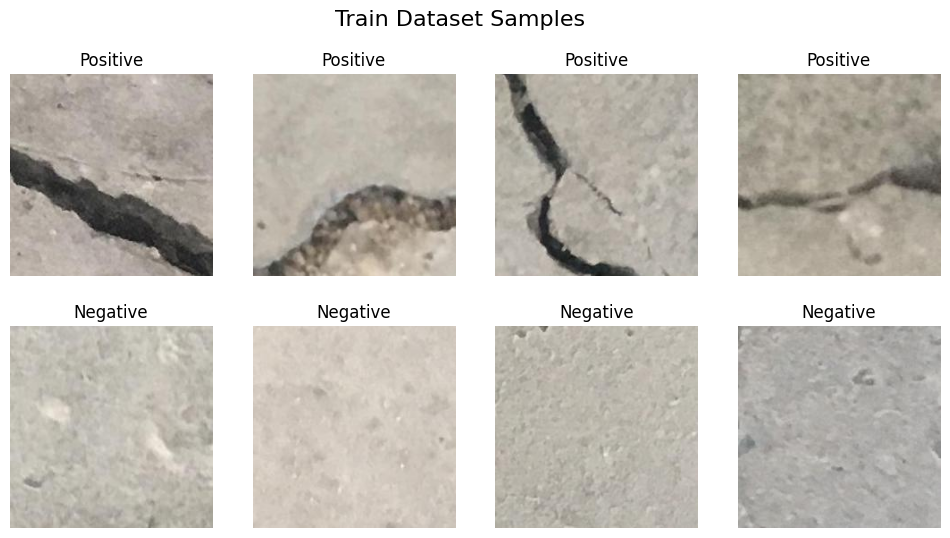

In [ ]:
# 이미지 시각화
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Train Dataset Samples", fontsize=16)

for i, file_path in enumerate(positive_paths):
    image = Image.open(file_path)
    axes[0, i].imshow(image)
    axes[0, i].axis("off")
    axes[0, i].set_title("Positive")

for i, file_path in enumerate(negative_paths):
    image = Image.open(file_path)
    axes[1, i].imshow(image)
    axes[1, i].axis("off")
    axes[1, i].set_title("Negative")
plt.show()

## 데이터 전처리

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # -1 ~ 1까지로 변형
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# negative 폴더가 0, positive 폴더가 1로 자동 라벨링
train_dataset = ImageFolder('/content/train',transform=transform)
val_dataset = ImageFolder('/content/val',transform=transform)

len(train_dataset),len(val_dataset)


(24000, 8000)

In [ ]:
# 데이터셋의 10%만 쓸 예정
subset_ratio = 0.1

# 전체 데이터셋 크기 확인
total_train_size = len(train_dataset)
total_val_size = len(val_dataset)

# 10%로 줄일 크기 계산
train_subset_size = int(total_train_size * subset_ratio)
val_subset_size = int(total_val_size * subset_ratio)

# 랜덤하게 샘플 선택
train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
val_indices = np.random.choice(len(val_dataset), val_subset_size, replace=False)

# 기존 데이터셋에서 일부 샘플만 골라서 새로운 데이터셋을 만드는 클래스
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

# 데이터셋 크기 출력
print(f"Train dataset size after reduction: {len(train_dataset)}")
print(f"Validation dataset size after reduction: {len(val_dataset)}")

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Train dataset size after reduction: 2400
Validation dataset size after reduction: 800


## 2. vgg19
VGG19는 2014년 Visual Geometry Group(VGG)에서 개발한 합성곱 신경망(CNN) 모델로, ImageNet 대회(ILSVRC-2014)에서 우수한 성능을 보이며 널리 알려졌습니다. 총 19개 층(16개의 합성곱 층 + 3개의 완전연결 층)으로 구성되었으며, 모든 합성곱 층에서 3x3 필터를 사용하고, 최대 풀링을 통한 다운샘플링을 적용하여 깊은 계층에서도 효과적으로 특징을 학습할 수 있도록 설계되었습니다. VGG19는 깊은 구조를 통해 고해상도 이미지의 복잡한 패턴을 학습하는 데 강점이 있으며, 이미지 분류, 객체 검출, 스타일 트랜스퍼 등 다양한 컴퓨터 비전 작업에서 널리 활용됩니다.

- [논문](https://arxiv.org/pdf/2412.20345)

<img src="https://blog.kakaocdn.net/dna/Us1XD/btsPB4zzud1/AAAAAAAAAAAAAAAAAAAAADjyPkObfLKmgfWVWl2CmdiQDqABXNRjIDl471JOnDLA/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1753973999&allow_ip=&allow_referer=&signature=kiTqFpLYjiRAsrTDzk0GIPdpiro%3D">

In [ ]:
# VGG 모델 로드 및 네트워크 구조 확인
model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 77.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# 모델의 모든 파라미터를 고정
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
model.classifier[6] = nn.Linear(4096,2)
model.classifier[6].requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(optimizer_name, model, train_loader, val_loader, criterion, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f'지원하지 않는 최적화 알고리즘: {optimizer_name}')
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        val_loss = 0.0
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)
            print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%', flush=True)
    return train_losses, val_losses, val_accuracies

### 언제 Adam과 RAdam을 사용할까?

- Adam : 기본적으로 가장 많이 사용되는 최적화 알고리즘이며, 다양한 모델에서 잘 동작함.
- RAdam : 학습 초반에 불안정한 동작을 보이는 경우 (예: 작은 배치 크기, 불안정한 손실 함수)에는 Adam보다 RAdam이 더 좋은 선택.(= 손실함수가 많이 튄다!)
    - 분산을 사용해서 분산에서 벗어난 값들을 안정화시킨다.
> 즉, Adam을 먼저 사용하고, 학습이 불안정하면 RAdam을 고려하는 것이 일반적인 전략입니다.

<img src="https://blog.kakaocdn.net/dna/tFegV/btsPC7vyyrO/AAAAAAAAAAAAAAAAAAAAADZpYLnreJzoVYrvZlJy6g0_KIEjAfgRbfcv-3vjlhI9/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1753973999&allow_ip=&allow_referer=&signature=UOxRwh5BwwCq8Ztrm%2FY3hih6PEs%3D">


In [ ]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', model, train_loader, val_loader, criterion)

[SGD] Epoch 1, Train Loss: 0.251112, Val Loss: 0.105666, Validation Accuracy: 97.25%
[SGD] Epoch 2, Train Loss: 0.112896, Val Loss: 0.083239, Validation Accuracy: 97.38%
[SGD] Epoch 3, Train Loss: 0.092885, Val Loss: 0.075690, Validation Accuracy: 97.38%
[SGD] Epoch 4, Train Loss: 0.085312, Val Loss: 0.064702, Validation Accuracy: 97.75%
[SGD] Epoch 5, Train Loss: 0.074302, Val Loss: 0.060349, Validation Accuracy: 98.00%
[SGD] Epoch 6, Train Loss: 0.074035, Val Loss: 0.059247, Validation Accuracy: 98.00%
[SGD] Epoch 7, Train Loss: 0.068152, Val Loss: 0.054944, Validation Accuracy: 98.25%
[SGD] Epoch 8, Train Loss: 0.068684, Val Loss: 0.057676, Validation Accuracy: 97.88%
[SGD] Epoch 9, Train Loss: 0.065922, Val Loss: 0.057500, Validation Accuracy: 97.75%
[SGD] Epoch 10, Train Loss: 0.062132, Val Loss: 0.056106, Validation Accuracy: 97.88%
[SGD] Epoch 11, Train Loss: 0.066212, Val Loss: 0.051777, Validation Accuracy: 98.12%
[SGD] Epoch 12, Train Loss: 0.061408, Val Loss: 0.049301, Valid

In [ ]:
# 초기화
model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = True

# Adam
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.177700, Val Loss: 0.077119, Validation Accuracy: 97.50%
[Adam] Epoch 2, Train Loss: 0.071633, Val Loss: 0.066701, Validation Accuracy: 97.38%
[Adam] Epoch 3, Train Loss: 0.060438, Val Loss: 0.058132, Validation Accuracy: 97.62%
[Adam] Epoch 4, Train Loss: 0.057158, Val Loss: 0.051190, Validation Accuracy: 98.00%
[Adam] Epoch 5, Train Loss: 0.044457, Val Loss: 0.047592, Validation Accuracy: 98.25%
[Adam] Epoch 6, Train Loss: 0.044601, Val Loss: 0.041623, Validation Accuracy: 98.62%
[Adam] Epoch 7, Train Loss: 0.041315, Val Loss: 0.040429, Validation Accuracy: 98.62%
[Adam] Epoch 8, Train Loss: 0.038982, Val Loss: 0.042574, Validation Accuracy: 98.62%
[Adam] Epoch 9, Train Loss: 0.033698, Val Loss: 0.042049, Validation Accuracy: 98.50%
[Adam] Epoch 10, Train Loss: 0.035315, Val Loss: 0.044782, Validation Accuracy: 98.62%
[Adam] Epoch 11, Train Loss: 0.040285, Val Loss: 0.044742, Validation Accuracy: 98.50%
[Adam] Epoch 12, Train Loss: 0.032676, Val Loss: 0.0

In [ ]:
# 초기화
model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = True

# Adam
train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', model, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.170556, Val Loss: 0.077272, Validation Accuracy: 97.62%
[RAdam] Epoch 2, Train Loss: 0.070506, Val Loss: 0.062319, Validation Accuracy: 97.50%
[RAdam] Epoch 3, Train Loss: 0.055846, Val Loss: 0.054093, Validation Accuracy: 98.00%
[RAdam] Epoch 4, Train Loss: 0.047238, Val Loss: 0.050805, Validation Accuracy: 98.12%
[RAdam] Epoch 5, Train Loss: 0.044985, Val Loss: 0.053936, Validation Accuracy: 97.75%
[RAdam] Epoch 6, Train Loss: 0.045782, Val Loss: 0.041804, Validation Accuracy: 98.62%
[RAdam] Epoch 7, Train Loss: 0.039097, Val Loss: 0.041532, Validation Accuracy: 98.62%
[RAdam] Epoch 8, Train Loss: 0.038576, Val Loss: 0.041068, Validation Accuracy: 98.50%
[RAdam] Epoch 9, Train Loss: 0.040546, Val Loss: 0.040532, Validation Accuracy: 98.50%
[RAdam] Epoch 10, Train Loss: 0.037078, Val Loss: 0.043377, Validation Accuracy: 98.38%
[RAdam] Epoch 11, Train Loss: 0.041730, Val Loss: 0.042689, Validation Accuracy: 98.38%
[RAdam] Epoch 12, Train Loss: 0.037347, V

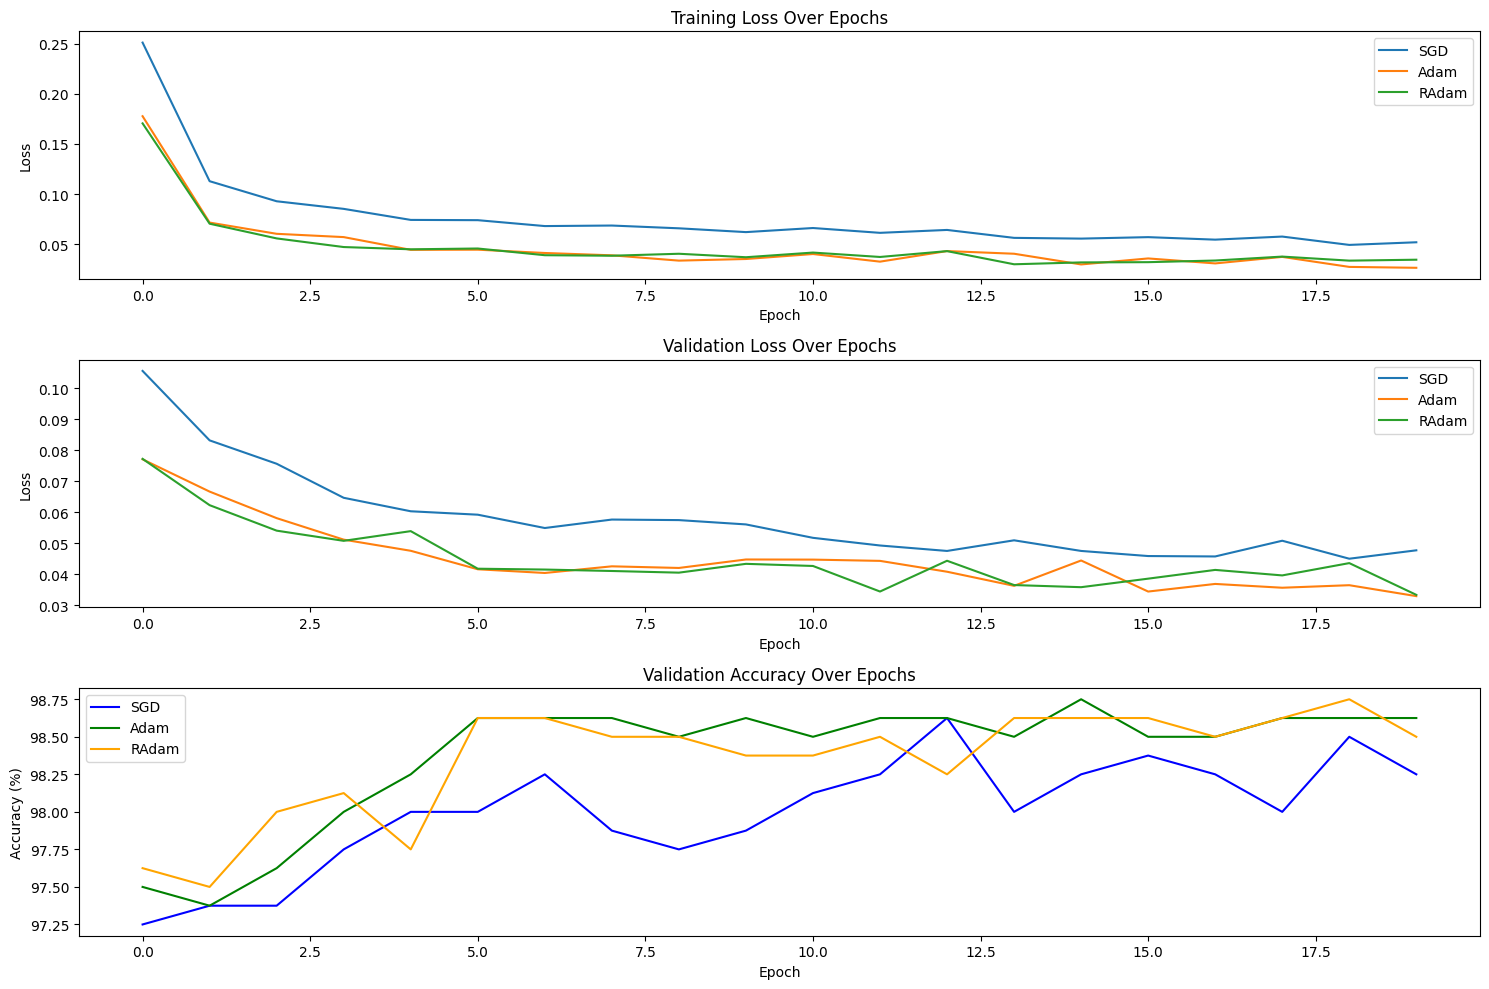

In [ ]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(val_accuracies_RAdam, label='RAdam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

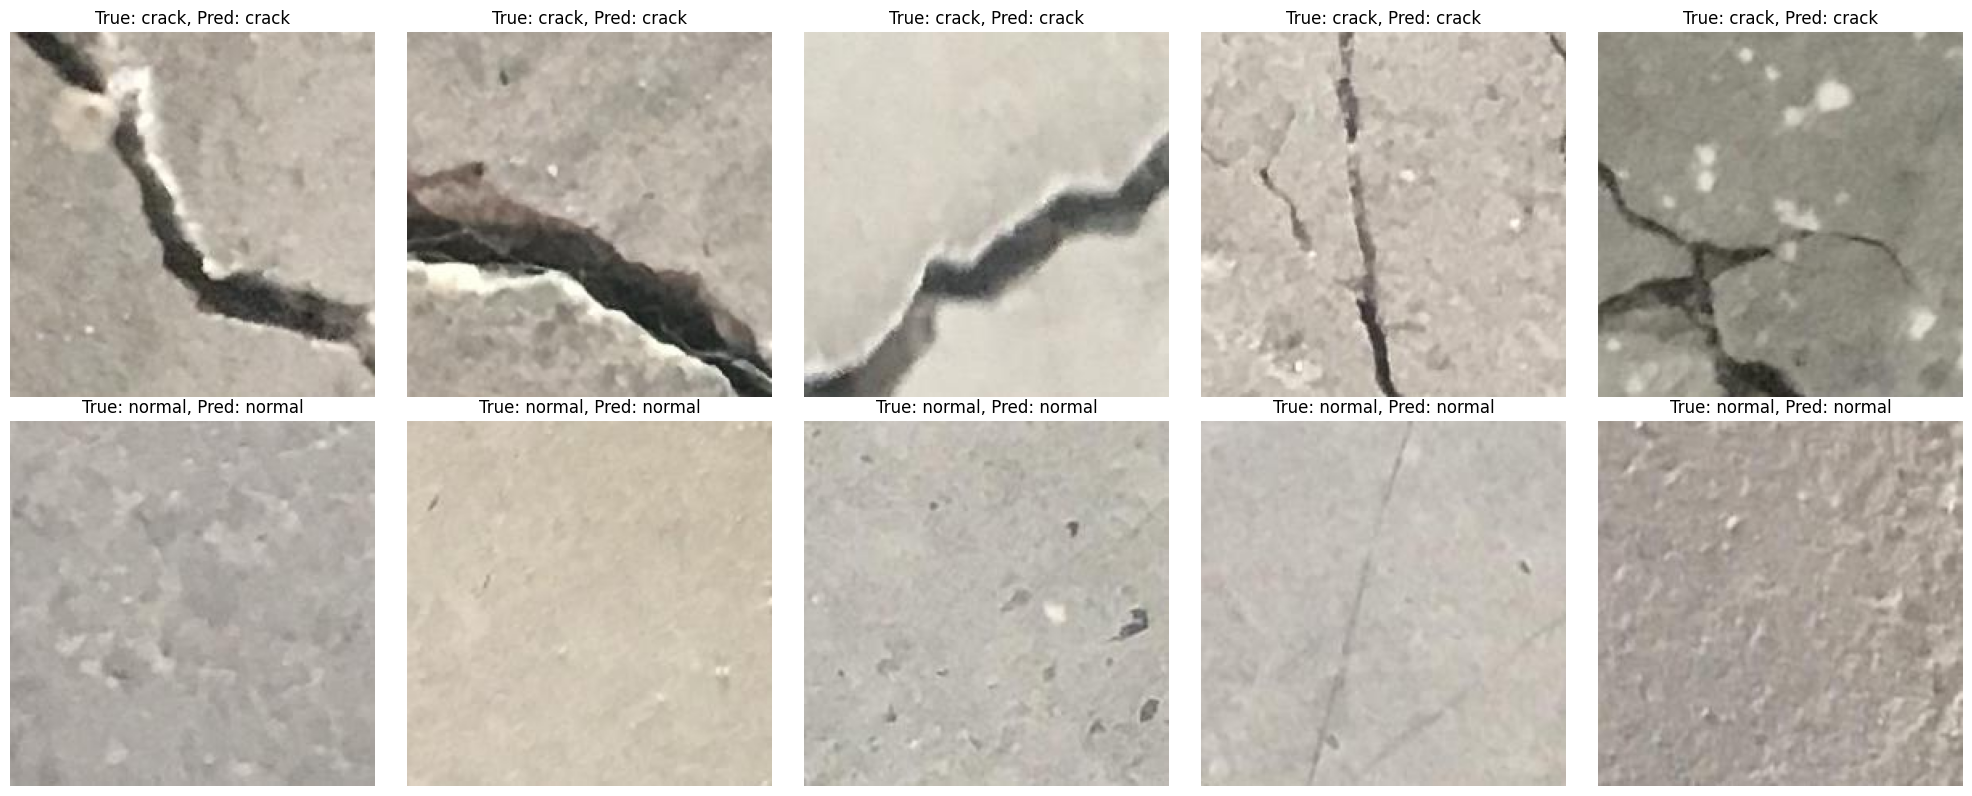

In [ ]:
# 클래스별 폴더 경로
class_folders = {
    'crack': '/content/test/positive',
    'normal': '/content/test/negative'
}

# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        image = image.to(device)

        model.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'normal' if predicted.item() == 0 else 'crack'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()